## Use Deseq2 normalized data

In [99]:
import pandas as pd
counts = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")
counts = counts[~counts["Name"].str.contains("frag", case=False, na=False)]   # remove stxbp1-frag rows

frag_miRNA = pd.read_csv("fragment-miRNA.csv")

In [100]:
df_mut = counts[counts['Name'].str.contains('mutated', case=False, na=False)]
print(len(df_mut))

490


In [101]:
counts_miRNA = pd.merge(counts, frag_miRNA, on="Name")

miRNA = []
for i in counts_miRNA['miRNA']:
    miRNA.append(i.split(":")[1])   # remove the front characters(gene name) of in the column of miRNA 
counts_miRNA['miRNA'] = miRNA

print(counts_miRNA.head())

counts_miRNA.to_csv("counts_miRNA_hek.csv",sep=',')  

                          Name     baseMean  log2FoldChange     lfcSE  \
0   AAGAB|ENST00000261880.10|2  2489.885932        0.511739  0.143115   
1   AAGAB|ENST00000261880.10|3  6038.426170        0.867749  0.072504   
2   AAGAB|ENST00000261880.10|6  3204.806949        0.231531  0.081289   
3   AAGAB|ENST00000261880.10|7  4088.556499        0.314733  0.082717   
4  AAGAB|ENST00000261880.10|13   548.313250       -3.293426  0.150276   

        stat         pvalue           padj                             Seq  \
0   3.575721   3.492642e-04   4.715106e-04  TTAGTTTTTAGTAGGAGGTTAAGGAGAAAT   
1  11.968271   5.210315e-33   2.027268e-32  TAAATCTCAGAGGTCTGTGTGATTTACTCA   
2   2.848244   4.396126e-03   5.558960e-03  ACTGAGTTGTGGGGGATATGTTGTATGTTA   
3   3.804921   1.418495e-04   1.954407e-04  TTGAGATGCCAGAGCTGTGTTGTTGCACAC   
4 -21.915801  1.836341e-106  3.812715e-105  TGGGATTGCAAAAAAAAAAAAAAGGTGGAA   

   hek-gDNA1  hek-gDNA2  ...  hek-RNA3  sk-gDNA1  sk-gDNA2  sk-gDNA3  sk-RNA1  \
0       220

In [102]:
# remove the duplicate based on "Name", and only keep the last occurrences.
counts_miRNA_1 = counts_miRNA.drop_duplicates(subset=['Name'], keep='last')
counts_miRNA_1.head()

counts_miRNA_1.to_csv("counts_miRNA_hek1.csv",sep=',') 

In [103]:
counts_non_miRNA=counts[~counts.Name.isin(counts_miRNA_1.Name)]
counts_non_miRNA.to_csv("counts_non_miRNA_hek.csv",sep=',') 

In [104]:
print(counts_miRNA_1.shape)
print(counts_non_miRNA.shape)

(4276, 23)
(6964, 22)


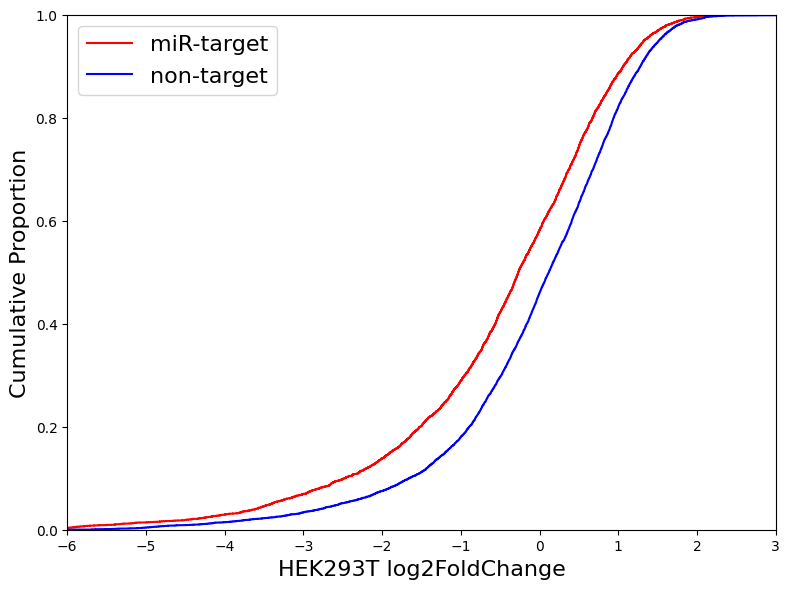

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate ratios for both non-miRNA and miRNA datasets
Ratio_non = counts_non_miRNA['log2FoldChange']
Ratio_miR = counts_miRNA_1['log2FoldChange']

# Combine the data into a single DataFrame for easy plotting
df_cleaned = pd.DataFrame({'ratio_non_miRNA': Ratio_non, 'ratio_miRNA': Ratio_miR})

# Plot ECDF for both datasets
plt.figure(figsize=(8, 6))
sns.ecdfplot(df_cleaned['ratio_miRNA'], label='miR-target', color='red')
sns.ecdfplot(df_cleaned['ratio_non_miRNA'], label='non-target', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', color='green')

# Customize the plot
plt.xlim(-6, 3)  # Adjust range as needed
plt.ylim(0, 1)
plt.xlabel("HEK293T log2FoldChange", fontsize=16)
plt.ylabel("Cumulative Proportion", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()


In [106]:
from scipy.stats import mannwhitneyu
import numpy as np

# Replace infinite values by NaN
counts_non_miRNA['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
counts_miRNA_1['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
counts_non_miRNA.dropna(subset=['log2FoldChange'], inplace=True)
counts_miRNA_1.dropna(subset=['log2FoldChange'], inplace=True)

# Perform the Mann-Whitney U test if both groups are non-empty
if not counts_non_miRNA.empty and not counts_miRNA_1.empty:
    u_stat, p_value = mannwhitneyu(counts_non_miRNA['log2FoldChange'], counts_miRNA_1['log2FoldChange'], alternative='two-sided')
    print("U-statistic:", u_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform U-test due to an empty group.")


U-statistic: 17576573.0
P-value: 2.929390596655578e-58


/tmp/ipykernel_778292/976193062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_non_miRNA['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/976193062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_miRNA_1['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/976193062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_non_miRNA.drop

## Analysis miR7 & miR124

In [107]:
import pandas as pd


# Load data 
df = pd.read_csv('fragment-miRNA.csv')

# Filter the rows with miR-7-5p and miR-124-3p

df_miR7 = df[df['miRNA'].str.contains('miR-7-5p')]
df_miR124 = df[df['miRNA'].str.contains('miR-124')]

print(df_miR7.head(),len(df_miR7))
print(df_miR124.head(),len(df_miR124))

                           Name           miRNA
209   AKT3|ENST00000673466.1|28   AKT3:miR-7-5p
210   AKT3|ENST00000673466.1|29   AKT3:miR-7-5p
460  ARID2|ENST00000334344.11|8  ARID2:miR-7-5p
469  ARID2|ENST00000334344.11|9  ARID2:miR-7-5p
498  ASXL1|ENST00000375687.10|2  ASXL1:miR-7-5p 68
                          Name                     miRNA
18   ABCD1|ENST00000218104.6|6        ABCD1:miR-124-3p.1
25   ABCD1|ENST00000218104.6|7        ABCD1:miR-124-3p.1
55    ACTB|ENST00000646664.1|3  ACTB:miR-124-3p.2/506-3p
57    ACTB|ENST00000646664.1|4  ACTB:miR-124-3p.2/506-3p
219  AKT3|ENST00000673466.1|37         AKT3:miR-124-3p.1 334


In [108]:
# merge filtered df with original counts
import pandas as pd

counts = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_hek_df100.csv")
counts = counts[~counts["Name"].str.contains("frag", case=False, na=False)]

df_w_miR7 = pd.merge(left=counts,right=df_miR7, on='Name', how='inner')
df_w_miR124 = pd.merge(left=counts,right=df_miR124, on='Name', how='inner')

print(len(df_w_miR7), df_w_miR7.head())

68                          Name      baseMean  log2FoldChange     lfcSE  \
0   AKT3|ENST00000673466.1|28  10611.113223        1.162679  0.083290   
1   AKT3|ENST00000673466.1|29   6448.327633        0.898689  0.085121   
2  ARID2|ENST00000334344.11|8   1661.699826        0.526848  0.113153   
3  ARID2|ENST00000334344.11|9   8785.804929        2.008914  0.127389   
4  ASXL1|ENST00000375687.10|2   7199.908242        0.797472  0.076677   

        stat        pvalue          padj                             Seq  \
0  13.959480  2.754374e-44  1.493095e-43  ACACATAGGGGATCATTTTTACTTCAGTGA   
1  10.557758  4.676977e-26  1.457980e-25  ATGAAGGAGGTCTCAGACCCTGGGGACATT   
2   4.656051  3.223324e-06  4.844489e-06  ATGTCATTTTTTAGAAGAAAAACTATTTGA   
3  15.769913  5.011847e-56  3.720069e-55  ATGGAATTTTATACAGGTTTTCTCCTGTGT   
4  10.400359  2.470016e-25  7.540976e-25  ACTGCTAAAGCCCTCTGTCACTTGGCGACC   

   hek-gDNA1  hek-gDNA2  ...  hek-RNA3  sk-gDNA1  sk-gDNA2  sk-gDNA3  sk-RNA1  \
0       8147       7

In [109]:
# Extract the different part of two df
df = pd.merge(left=counts,right=df_miR7, how='left', indicator=True, on='Name')
df_wo_miR7 = df.loc[df._merge == 'left_only', :].drop(columns='_merge')
print(len(df_wo_miR7))

df = pd.merge(left=counts,right=df_miR124, how='left', indicator=True, on='Name')
df_wo_miR124 = df.loc[df._merge == 'left_only', :].drop(columns='_merge')
print(len(df_wo_miR124))

11172
11000


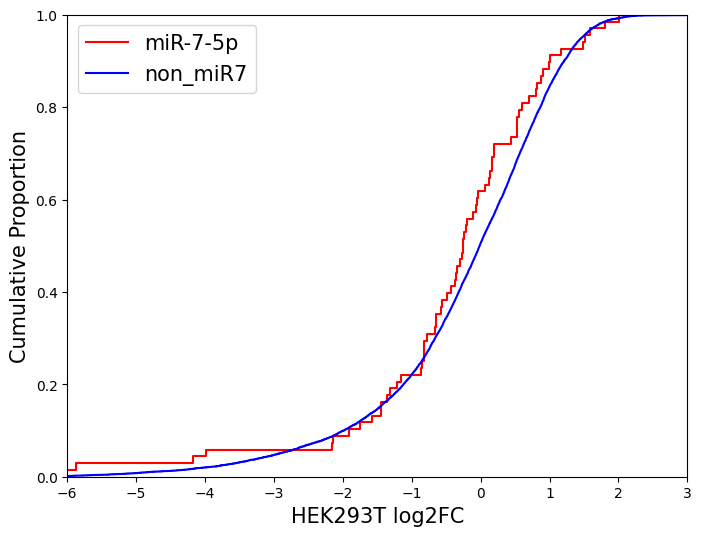

In [110]:
# draw ecdf plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 6))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR7['log2FoldChange'], label='miR-7-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR7['log2FoldChange'], label='non_miR7', linestyle='-', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', linestyle='-', color='green')

plt.xlim(-6, 3)
plt.ylim(0, 1)
plt.xlabel("HEK293T log2FC", fontsize=15)
plt.ylabel("Cumulative Proportion", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

In [111]:
from scipy.stats import mannwhitneyu
import numpy as np

# Replace infinite values by NaN
df_w_miR7['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR7['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
df_w_miR7.dropna(subset=['log2FoldChange'], inplace=True)
df_wo_miR7.dropna(subset=['log2FoldChange'], inplace=True)

# Perform the Mann-Whitney U test if both groups are non-empty
if not df_w_miR7.empty and not df_wo_miR7.empty:
    u_stat, p_value = mannwhitneyu(df_w_miR7['log2FoldChange'], df_wo_miR7['log2FoldChange'], alternative='two-sided')
    print("U-statistic:", u_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform U-test due to an empty group.")


U-statistic: 343953.0
P-value: 0.1784513883955804


/tmp/ipykernel_778292/1439581977.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR7['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/1439581977.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

## miR124

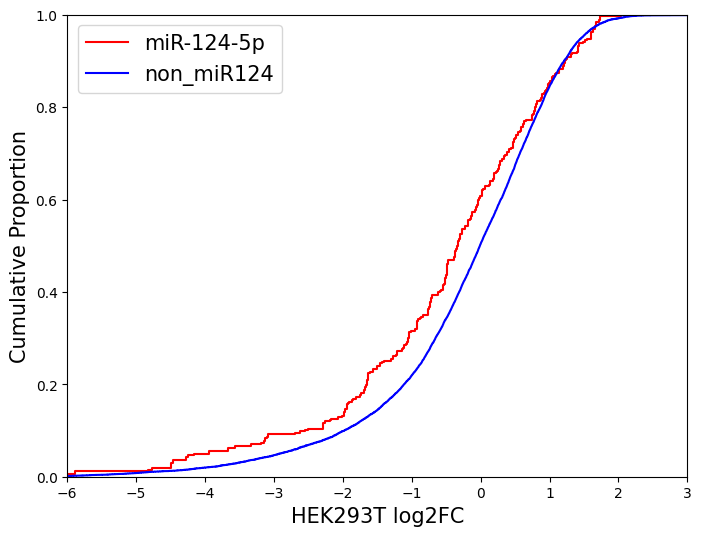

In [112]:
# draw ecdf plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 6))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR124['log2FoldChange'], label='miR-124-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR124['log2FoldChange'], label='non_miR124', linestyle='-', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', linestyle='-', color='green')

plt.xlim(-6, 3)
plt.ylim(0, 1)
plt.xlabel("HEK293T log2FC", fontsize=15)
plt.ylabel("Cumulative Proportion", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

In [113]:
from scipy.stats import mannwhitneyu
import numpy as np

# Replace infinite values by NaN
df_w_miR124['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR124['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
df_w_miR124.dropna(subset=['log2FoldChange'], inplace=True)
df_wo_miR124.dropna(subset=['log2FoldChange'], inplace=True)

# Perform the Mann-Whitney U test if both groups are non-empty
if not df_w_miR124.empty and not df_wo_miR124.empty:
    u_stat, p_value = mannwhitneyu(df_w_miR124['log2FoldChange'], df_wo_miR124['log2FoldChange'], alternative='two-sided')
    print("U-statistic:", u_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform U-test due to an empty group.")


U-statistic: 1581675.0
P-value: 0.0002809411613759952


/tmp/ipykernel_778292/14741959.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR124['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/14741959.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

## SK cell line

In [114]:
import pandas as pd
counts = pd.read_csv("/home/yg2895/media/protein/yg2895/ASO-lib-20250102/DE_analyse/filerted_sk_df100.csv")
frag_miRNA = pd.read_csv("fragment-miRNA.csv")

In [115]:
df_mut = counts[counts['Name'].str.contains('mutated', case=False, na=False)]
print(len(df_mut))

487


In [116]:
counts_miRNA = pd.merge(counts, frag_miRNA, on="Name")

miRNA = []
for i in counts_miRNA['miRNA']:
    miRNA.append(i.split(":")[1])   # remove the front characters(gene name) of in the column of miRNA 
counts_miRNA['miRNA'] = miRNA
counts_miRNA.to_csv("counts_miRNA_sk.csv",sep=',')  

# remove the duplicate based on "Name", and only keep the last occurrences.
counts_miRNA_1 = counts_miRNA.drop_duplicates(subset=['Name'], keep='last')
counts_miRNA_1.head()
counts_miRNA_1.to_csv("counts_miRNA_sk_1.csv",sep=',') 

counts_non_miRNA=counts[~counts.Name.isin(counts_miRNA_1.Name)]
counts_non_miRNA.to_csv("counts_non_miRNA_sk.csv",sep=',') 

Median non-miRNA ratio: 0.19
Median miRNA ratio: -0.24
T-statistic: 8.293, P-value: 1.4145012672205896e-16


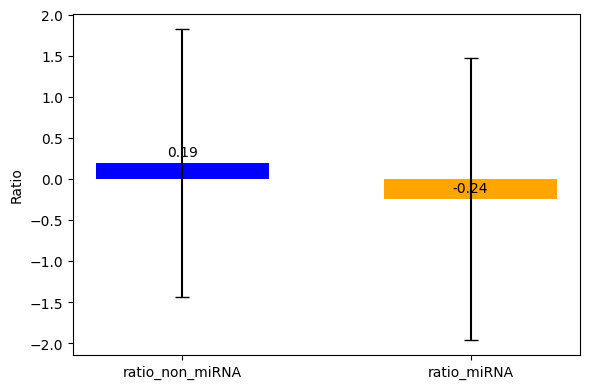

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

Ratio_non = counts_non_miRNA['log2FoldChange']
Ratio_miR = counts_miRNA_1['log2FoldChange']

# Combine both ratios into a single DataFrame
df = pd.DataFrame({'ratio_non_miRNA': Ratio_non, 'ratio_miRNA': Ratio_miR})

## Clean the data (remove NaN and infinite values)
df_cleaned = df.replace([np.inf, -np.inf], np.nan).dropna()

# Perform t-test
t_stat, p_value = ttest_ind(df_cleaned['ratio_non_miRNA'], df_cleaned['ratio_miRNA'], equal_var=False)

# Print results
print(f'Median non-miRNA ratio: {df_cleaned["ratio_non_miRNA"].median():.2f}')
print(f'Median miRNA ratio: {df_cleaned["ratio_miRNA"].median():.2f}')
print(f'T-statistic: {t_stat:.3f}, P-value: {p_value}')

# Plot the data
medians = df_cleaned.median()
std_devs = df_cleaned.std()

plt.figure(figsize=(6, 4))
bars = plt.bar(df_cleaned.columns, medians, yerr=std_devs, capsize=5, color=['blue', 'orange'],width=0.6)

# Annotate the bars with median values
for bar, median in zip(bars, medians):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{median:.2f}', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Ratio')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

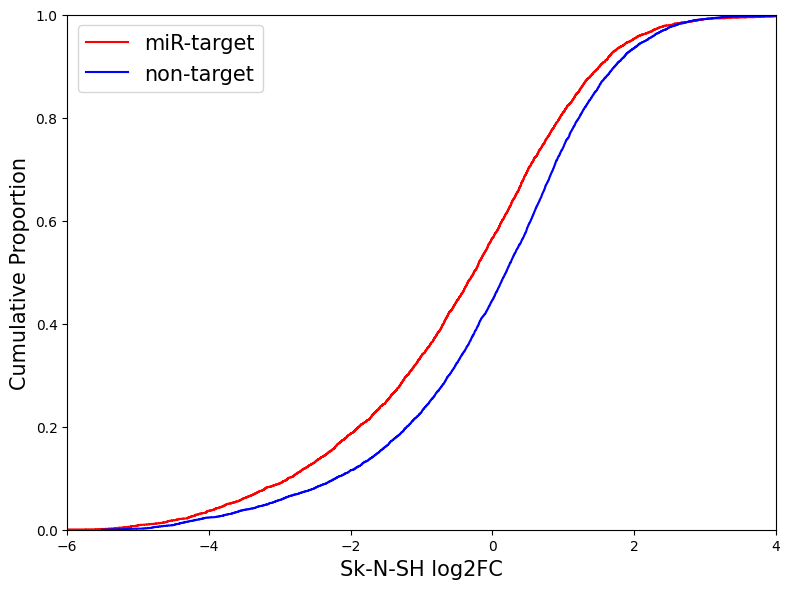

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate ratios for both non-miRNA and miRNA datasets
Ratio_non = counts_non_miRNA['log2FoldChange']
Ratio_miR = counts_miRNA_1['log2FoldChange']

# Combine the data into a single DataFrame for easy plotting
df_cleaned = pd.DataFrame({'ratio_non_miRNA': Ratio_non, 'ratio_miRNA': Ratio_miR})

# Plot ECDF for both datasets
plt.figure(figsize=(8, 6))
sns.ecdfplot(df_cleaned['ratio_miRNA'], label='miR-target', color='red')
sns.ecdfplot(df_cleaned['ratio_non_miRNA'], label='non-target', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', color='green')
# Customize the plot
plt.xlim(-6, 4)  # Adjust range as needed
plt.ylim(0, 1)
plt.xlabel("Sk-N-SH log2FC", fontsize=15)
plt.ylabel("Cumulative Proportion", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()


In [119]:
from scipy.stats import mannwhitneyu
import numpy as np

# Replace infinite values by NaN
counts_non_miRNA['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
counts_miRNA_1['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
counts_non_miRNA.dropna(subset=['log2FoldChange'], inplace=True)
counts_miRNA_1.dropna(subset=['log2FoldChange'], inplace=True)

# Perform the Mann-Whitney U test if both groups are non-empty
if not counts_non_miRNA.empty and not counts_miRNA_1.empty:
    u_stat, p_value = mannwhitneyu(counts_non_miRNA['log2FoldChange'], counts_miRNA_1['log2FoldChange'], alternative='two-sided')
    print("U-statistic:", u_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform U-test due to an empty group.")

U-statistic: 17752583.0
P-value: 1.2252719261366204e-44


/tmp/ipykernel_778292/177010725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_non_miRNA['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/177010725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_miRNA_1['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/177010725.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_non_miRNA.drop

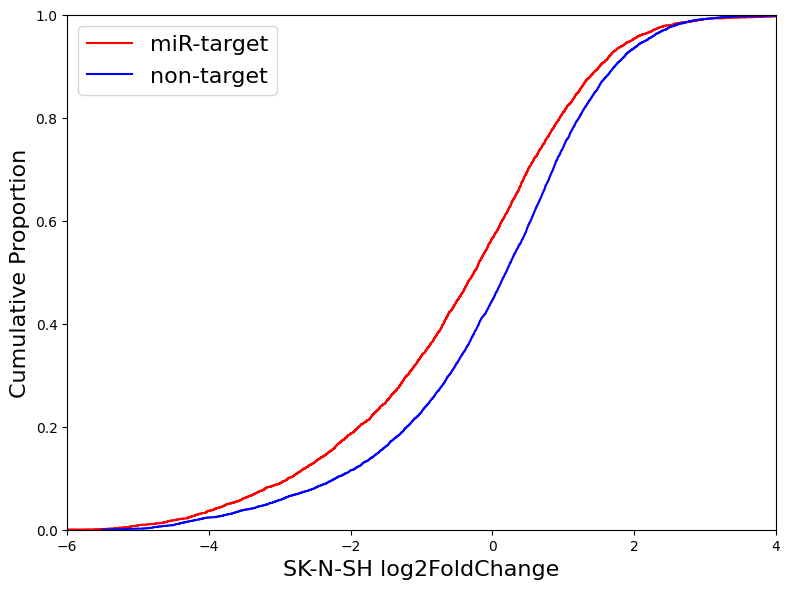

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate ratios for both non-miRNA and miRNA datasets
Ratio_non = counts_non_miRNA['log2FoldChange']
Ratio_miR = counts_miRNA_1['log2FoldChange']

# Combine the data into a single DataFrame for easy plotting
df_cleaned = pd.DataFrame({'ratio_non_miRNA': Ratio_non, 'ratio_miRNA': Ratio_miR})

# Plot ECDF for both datasets
plt.figure(figsize=(8, 6))
sns.ecdfplot(df_cleaned['ratio_miRNA'], label='miR-target', color='red')
sns.ecdfplot(df_cleaned['ratio_non_miRNA'], label='non-target', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', color='green')

# Customize the plot
plt.xlim(-6, 4)  # Adjust range as needed
plt.ylim(0, 1)
plt.xlabel("SK-N-SH log2FoldChange", fontsize=16)
plt.ylabel("Cumulative Proportion", fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()

In [121]:
import pandas as pd


# Load data 
df = pd.read_csv('fragment-miRNA.csv')

# Filter the rows with miR-7-5p and miR-124-3p

df_miR7 = df[df['miRNA'].str.contains('miR-7-5p')]
df_miR124 = df[df['miRNA'].str.contains('miR-124')]

print(df_miR7.head(),len(df_miR7))
print(df_miR124.head(),len(df_miR124))

                           Name           miRNA
209   AKT3|ENST00000673466.1|28   AKT3:miR-7-5p
210   AKT3|ENST00000673466.1|29   AKT3:miR-7-5p
460  ARID2|ENST00000334344.11|8  ARID2:miR-7-5p
469  ARID2|ENST00000334344.11|9  ARID2:miR-7-5p
498  ASXL1|ENST00000375687.10|2  ASXL1:miR-7-5p 68
                          Name                     miRNA
18   ABCD1|ENST00000218104.6|6        ABCD1:miR-124-3p.1
25   ABCD1|ENST00000218104.6|7        ABCD1:miR-124-3p.1
55    ACTB|ENST00000646664.1|3  ACTB:miR-124-3p.2/506-3p
57    ACTB|ENST00000646664.1|4  ACTB:miR-124-3p.2/506-3p
219  AKT3|ENST00000673466.1|37         AKT3:miR-124-3p.1 334


In [122]:
# merge filtered df with original counts
import pandas as pd

df_w_miR7 = pd.merge(left=counts,right=df_miR7, on='Name', how='inner')
df_w_miR124 = pd.merge(left=counts,right=df_miR124, on='Name', how='inner')

print(len(df_w_miR7), df_w_miR7.head())

# Extract the different part of two df
df = pd.merge(left=counts,right=df_miR7, how='left', indicator=True, on='Name')
df_wo_miR7 = df.loc[df._merge == 'left_only', :].drop(columns='_merge')
print(len(df_wo_miR7))

df = pd.merge(left=counts,right=df_miR124, how='left', indicator=True, on='Name')
df_wo_miR124 = df.loc[df._merge == 'left_only', :].drop(columns='_merge')
print(len(df_wo_miR124))

67                          Name      baseMean  log2FoldChange     lfcSE  \
0   AKT3|ENST00000673466.1|28   9324.264007        0.813601  0.189274   
1   AKT3|ENST00000673466.1|29   9138.520764        1.668591  0.149224   
2  ARID2|ENST00000334344.11|8    889.970593        1.348513  0.262138   
3  ARID2|ENST00000334344.11|9  23492.344765        4.060624  0.210083   
4  ASXL1|ENST00000375687.10|2   8674.591879        0.824395  0.205375   

        stat        pvalue          padj                             Seq  \
0   4.298542  1.719252e-05  3.001236e-05  ACACATAGGGGATCATTTTTACTTCAGTGA   
1  11.181753  5.009054e-29  2.817916e-28  ATGAAGGAGGTCTCAGACCCTGGGGACATT   
2   5.144288  2.685371e-07  5.403678e-07  ATGTCATTTTTTAGAAGAAAAACTATTTGA   
3  19.328622  3.085480e-83  1.029381e-81  ATGGAATTTTATACAGGTTTTCTCCTGTGT   
4   4.014093  5.967470e-05  9.934999e-05  ACTGCTAAAGCCCTCTGTCACTTGGCGACC   

   hek-gDNA1  hek-gDNA2  ...  hek-RNA3  sk-gDNA1  sk-gDNA2  sk-gDNA3  sk-RNA1  \
0       8147       7

## sk miR7

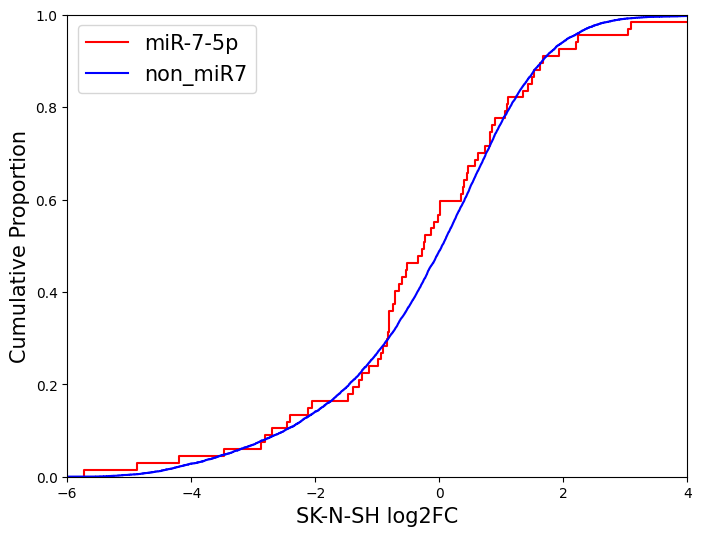

In [123]:
# draw ecdf plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 6))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR7['log2FoldChange'], label='miR-7-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR7['log2FoldChange'], label='non_miR7', linestyle='-', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', linestyle='-', color='green')

plt.xlim(-6, 4)
plt.ylim(0, 1)
plt.xlabel("SK-N-SH log2FC", fontsize=15)
plt.ylabel("Cumulative Proportion", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

In [124]:
# Replace infinite values by NaN
df_w_miR7['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR7['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
# Drop NaNs introduced by infinity replacement or present otherwise
df_w_miR7.dropna(subset=['log2FoldChange'], inplace=True)
df_wo_miR7.dropna(subset=['log2FoldChange'], inplace=True)

# Recompute standard deviations
std_w_miR7 = df_w_miR7['log2FoldChange'].std()
std_wo_miR7 = df_wo_miR7['log2FoldChange'].std()

# Perform the t-test if both standard deviations are non-zero
if std_w_miR7 != 0 and std_wo_miR7 != 0:
    t_stat, p_value = ttest_ind(df_w_miR7['log2FoldChange'], df_wo_miR7['log2FoldChange'], equal_var=False, nan_policy='omit')
    print("T-statistic:", t_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform t-test due to zero standard deviation in one of the groups.")

T-statistic: -0.39736990960013774
P-value: 0.6923645594062877


/tmp/ipykernel_778292/3013576189.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR7['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/3013576189.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

## Sk miR124

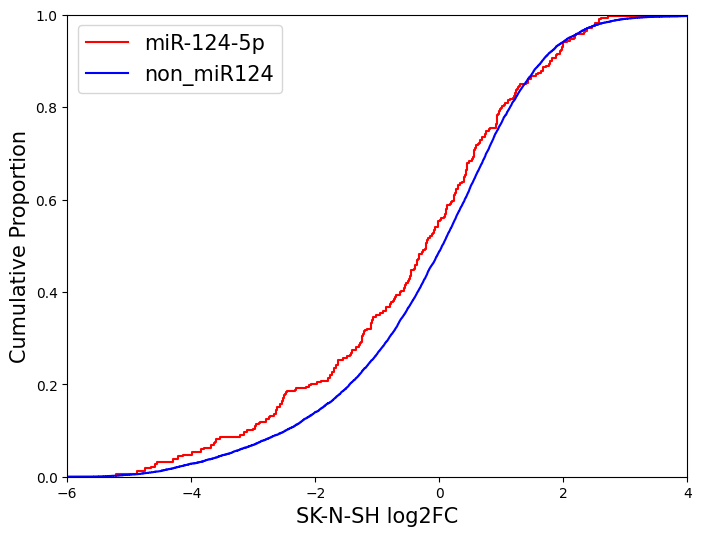

In [125]:
# draw ecdf plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting ECDF
plt.figure(figsize=(8, 6))

# Empirical Cumulative Distribution Function plot
sns.ecdfplot(df_w_miR124['log2FoldChange'], label='miR-124-5p', linestyle='-', color='red')
sns.ecdfplot(df_wo_miR124['log2FoldChange'], label='non_miR124', linestyle='-', color='blue')
# sns.ecdfplot(df_mut['log2FoldChange'], label='mutated', linestyle='-', color='green')

plt.xlim(-6, 4)
plt.ylim(0, 1)
plt.xlabel("SK-N-SH log2FC", fontsize=15)
plt.ylabel("Cumulative Proportion", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

In [126]:
# Replace infinite values by NaN
df_w_miR124['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_wo_miR124['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaN values
# Drop NaNs introduced by infinity replacement or present otherwise
df_w_miR124.dropna(subset=['log2FoldChange'], inplace=True)
df_wo_miR124.dropna(subset=['log2FoldChange'], inplace=True)

# Recompute standard deviations
std_w_miR124 = df_w_miR124['log2FoldChange'].std()
std_wo_miR124 = df_wo_miR124['log2FoldChange'].std()

# Perform the t-test if both standard deviations are non-zero
if std_w_miR124 != 0 and std_wo_miR124 != 0:
    t_stat, p_value = ttest_ind(df_w_miR124['log2FoldChange'], df_wo_miR124['log2FoldChange'], equal_var=False, nan_policy='omit')
    print("T-statistic:", t_stat)
    print("P-value:", p_value)
else:
    print("Cannot perform t-test due to zero standard deviation in one of the groups.")

T-statistic: -2.7616500696236472
P-value: 0.006071564760044569


/tmp/ipykernel_778292/3001962750.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_w_miR124['log2FoldChange'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_778292/3001962750.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].